# Trading at the Close - Feature Engineering
-----------------------
-----------------------

Feature selection involves picking the set of features that are most relevant to the target variable. This helps in reducing the complexity of the model, as well as minimizing the resources required for training and inference. This has greater effect in production models where one maybe dealing with terabytes of data or serving millions of requests.

Most of the modules will come from [scikit-learn](https://scikit-learn.org/stable/), one of the most commonly used machine learning libraries. It features various machine learning algorithms and has built-in implementations of different feature selection methods. Using these, you will be able to compare which method works best for this particular dataset.

## Installs
-----------

In [1]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports
------------------



In [2]:
# for data processing and manipulation
import pandas as pd
import numpy as np
from pathlib import Path

# scikit-learn modules for feature selection and model evaluation
from sklearn.metrics import mean_absolute_error 
from lightgbm import LGBMRegressor
import lightgbm as lgb
from loguru import logger
from pprint import pformat, pprint

from utils.validation import TrainTestSplit

# libraries for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_style("ticks")

## Configuration
--------------------------

This cell defines the configuration to use throughout this notebook for feature selection.

In [3]:
class CFG:
    JOBS_PATH = Path(".", "job_artifacts")
    JOB_NAME = "optiver-feature_selection"
    TRAINING_PATH = Path(".", "train_files", "train.csv")
    AGGREGATIONS = "aggregations.json"
    SELECTED_FEATURES = "feature_names.json"
    COMPRESSED_TRAINING_DATA = "train_processed.parquet"
    TRAINING_DATA_STATS = "train_stats.csv"
    RANDOM_STATE = 1024
    USE_GPU = False
    MODEL = LGBMRegressor
    CROSSVAL = TrainTestSplit
    SHUFFLE = True # Not convenient in time series
    N_FOLDS = 1
    TEST_SIZE = 45
    N_JOBS = 1
    FEAT_COUNT= 50 # .-1 deactivates feature selection

In [4]:
def lgbm_params():
    """Returns algorithm parameters."""

    params = {
        "device"            : "gpu" if CFG.USE_GPU else "cpu",
        "objective"         : "mae",
        "boosting_type"     : "gbdt",
        "max_depth"         : 9,
        "num_leaves"        : 300,
        "learning_rate"     : 0.1,
        "n_estimators"      : 750,
        "subsample"         : 0.5,
        "colsample_bytree"  : 0.5,
        "reg_alpha"         : 0.005,
        "reg_lambda"        : 0.005,
        "random_state"      : CFG.RANDOM_STATE,
        "n_jobs"            : CFG.N_JOBS
    }

    return params


MODEL_CFG = {
    LGBMRegressor.__name__ : {
        "params_func": lgbm_params,
        "callbacks": [lgb.early_stopping(25)]
    }
}


WEIGHTS = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]

Create the artifacts folder tree incrementally. Each run will correspond to a different folder.

In [5]:
CFG.JOBS_PATH.mkdir(exist_ok=True, parents=True)

for i in range(1, 10000):
    CFG.JOB_PATH = CFG.JOBS_PATH.joinpath(CFG.JOB_NAME + "-" +  str(i).zfill(4))
    try:
        CFG.JOB_PATH.mkdir()
        break
    except:
        continue

## Define Helper Functions
-------------------------

The following cells define helper functions for feature creation and selection.

In [6]:
%%writefile utils/features.py

import numpy as np
import pandas as pd
from itertools import combinations
from typing import List, Mapping, Any
from numba import njit

try:
    from loguru import logger
except:
    import logging
    logger = logging.getLogger("__main__")

from .compression import downcast
from .utils import merge_df


# Log return
@njit
def log_return(series):
    return np.log(series).diff()


@njit
def moving_avg(arr: np.ndarray, window: int, min_periods: int = 1) -> np.ndarray:
    result = np.full(arr.shape, np.nan)  # Fill with nan
    if min_periods is None:
        min_periods = window

    for i in range(arr.shape[0]):
        windowed_data = arr[max(0, i - window + 1) : i + 1]
        valid_count = np.sum(~np.isnan(windowed_data))
        if valid_count >= min_periods:
            result[i] = np.nanmean(windowed_data)  # Compute mean considering possible NaN values

    return result

def get_moving_avg(x, lookback=10):
    x = x.to_numpy()
    return moving_avg(x, lookback)


@njit
def weighted_avg(values: np.ndarray, weights: np.ndarray):
    """
    Return the weighted average.

    values, weights -- NumPy ndarrays with the same shape.
    """
    masked_values = values[~np.isnan(values)]
    masked_weights = weights[~np.isnan(values)]

    return np.average(masked_values, weights=masked_weights)


def get_weighted_avg(x: pd.Series, weights: np.ndarray):

    stock_id = x["stock_id"]
    values = x.drop(columns=["stock_id"]).to_numpy().ravel()
    weights = weights[stock_id]

    return weighted_avg(values, weights)

@njit
def weighted_std(values, weights):
    """
    Return the weighted standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """

    masked_values = values[~np.isnan(values)]
    masked_weights = weights[~np.isnan(values)]

    average = np.average(masked_values, weights=masked_weights)

    # Fast and numerically precise:
    variance = np.average((masked_values - average)**2, weights=masked_weights)
    return np.sqrt(variance)


def get_weighted_std(x: pd.Series, weights: np.ndarray):

    stock_id = x["stock_id"]
    values = x.drop(columns=["stock_id"]).to_numpy().ravel()
    weights = weights[stock_id]

    return weighted_std(values, weights)


def get_rsi(x: pd.Series, length: int = 14):

    change = x.diff()
    gain = change.mask(change < 0, 0.0)
    loss = -change.mask(change > 0, -0.0)

    avg_gain = gain.ewm(alpha=1. / length, ignore_na=True).mean()
    avg_loss = loss.ewm(alpha=1. / length, ignore_na=True).mean()

    rsi = 100. - (100. / (1. + avg_gain / avg_loss))

    return rsi


def make_features(df: pd.DataFrame, reduce_memory: bool = True) -> None:
    """This function creates new features for analysis. Works fully in memory"""

    logger.info("Creating additional features...")

    eval_engine = "numexpr"
    # Volumes
    #df["ask_volume"] = df.eval("ask_size * ask_price", engine=eval_engine)
    #df["bid_volume"] = df.eval("bid_size * bid_price", engine=eval_engine)
    #df["spread_volume"] =  df.eval("ask_volume - bid_volume", engine=eval_engine)
    #df["total_volume"] = df.eval("ask_volume + bid_volume", engine=eval_engine)
    #df["ratio_volume"] = df.eval("bid_volume / ask_volume", engine=eval_engine)

    # Size features
    df["total_size"] = df.eval("ask_size + bid_size", engine=eval_engine) 
    df["spread_size"] = df.eval("ask_size - bid_size", engine=eval_engine) 
    df["ratio_size"] = df.eval("bid_size / ask_size", engine=eval_engine)

    # Imbalance features
    df["imb_ratio"] = df.eval("imbalance_size / matched_size", engine=eval_engine)
    df["imb_s1"] = df.eval("(bid_size - ask_size)/(bid_size + ask_size)", engine=eval_engine)
    df["imb_s2"] = df.eval("(imbalance_size - matched_size)/(matched_size + imbalance_size)", engine=eval_engine)

    # Encode imbalance flag as separate features
    df_encoded = pd.get_dummies(df["imbalance_buy_sell_flag"])
    df_encoded = df_encoded.rename(columns={
        -1: "sell_side_imbalance", 
        0 : "neutral_imbalance", 
        1: "buy_side_imbalance"
    }).astype(np.int8).drop(columns=["neutral_imbalance"])

    df = pd.concat([df, df_encoded], axis=1)

    # Price features
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2.", engine=eval_engine)

    # Combinations of price variables
    prices = ["reference_price", "ask_price", "bid_price", "wap", "far_price", "near_price"]
    # Price features
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_spread"] = df.eval(f"({c[0]} - {c[1]})", engine=eval_engine)
        df[f"{c[0]}_{c[1]}_imb1"] = df.eval(f"({c[0]}-{c[1]})/({c[0]}+{c[1]})", engine=eval_engine)
        #df[f"{c[0]}_{c[1]}_hmean"] = df.eval(f"(2. / ( 1. / {c[0]} + 1. / {c[1]}))", engine=eval_engine) # Harmonic mean


    for c in combinations(prices, 3):
        max_ = df[list(c)].max(axis=1)
        min_ = df[list(c)].min(axis=1)
        mid_ = df[list(c)].sum(axis=1) - min_ - max_

        df[f"{c[0]}_{c[1]}_{c[2]}_imb2"] = (max_ - mid_)/(mid_ - min_)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df


def make_aggregated_features(df: pd.DataFrame, weights: List[float] = None, reduce_memory: bool = False):

    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)

    apply_engine = "numba"
    sample = df.groupby(["date_id", "seconds_in_bucket"], group_keys=False, sort=False)


    date_aggregations = {}

    sizes = ["total_size", "spread_size", "ratio_size", "imb_s1", "imb_s2", "imb_ratio", "matched_size", "imbalance_size"]
    sizes = []
    for size in sizes:
        date_aggregations["mean_" + size] = sample[size].mean(engine=apply_engine).to_dict()
        date_aggregations["std_" + size] = sample[size].std(engine=apply_engine).to_dict()

    prices = ["wap", "reference_price", "ask_price", "bid_price"]
    prices = []
    for price in prices:
        if weights is not None:
            date_aggregations["weighted_mean_" + price] = sample[[price, "stock_id"]].apply(lambda x: get_weighted_avg(x, weights=weights)).to_dict()
            date_aggregations["weighted_std_" + price] = sample[[price, "stock_id"]].apply(lambda x: get_weighted_std(x, weights=weights)).to_dict()

        else:
            date_aggregations["mean_" + price] = sample[price].mean(engine=apply_engine).to_dict()
            date_aggregations["std_" + price] = sample[price].std(engine=apply_engine).to_dict()


    # Perform aggregations and features dependent on these
    logger.info("Applying date-wise aggregations...")
    for key, value in date_aggregations.items():
        aggr_index = ["date_id", "seconds_in_bucket"]
        aggr_colum = pd.Series(value, name=key + "_date_aggr")
        aggr_colum.index = aggr_colum.index.set_names(aggr_index)
        df = pd.merge(df, aggr_colum, on=aggr_index)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df



def make_rolling_features(df: pd.DataFrame, windows: List[float] = [12, 24, 36, 48], reduce_memory: bool = True) -> None:

    apply_engine = "numba"

    sample_date = df.groupby(["stock_id", "seconds_in_bucket"])
    # Add lagged target
    df[f"revealed_target"] = sample_date["target"].shift(1)

    sample_stock = df.groupby(["stock_id"])
    prices = ["reference_price", "ask_price", "bid_price", "wap", "far_price", "near_price"]
    sizes = ["total_size", "spread_size", "ratio_size", "imb_s1", "imb_s2", "imb_ratio", "matched_size", "imbalance_size"]
    sizes = []
    prices = []
    # Adding previous date target as feature
    for window in windows:
        for elem in prices + sizes:
            df[f"{elem}_SMA{window * 10}"] = sample_stock[elem].rolling(window, min_periods=1).mean(engine=apply_engine)
            df[f"{elem}_std{window * 10}"] = sample_stock[elem].rolling(window, min_periods=1).std(engine=apply_engine)

    prices = ["wap"]
    for elem in prices + sizes:
        df[f"{elem}_MACD"] = (sample_stock[elem].ewm(12, ignore_na=True).mean() - \
                              sample_stock[elem].ewm(26, ignore_na=True).mean()).reset_index()[elem]
        
        df[f"{elem}_RSI"] = sample_stock[elem].apply(get_rsi).reset_index()[elem]


    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df


def select_features(df: pd.DataFrame, features: List[str] = None, reduce_memory: bool = True) -> None:
    """This function dorps features. Works fully in memory"""

    if features is not None:
        logger.info("Dropping unnecesary features...")
        df.drop(columns=[elem for elem in df.columns if elem not in features], inplace=True)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df


Overwriting utils/features.py


In [7]:
%%writefile utils/cleaning.py

import numpy as np
import pandas as pd
from typing import List

try:
    from loguru import logger
except:
    import logging
    logger = logging.getLogger("__main__")


def clean(df: pd.DataFrame) -> None:
    """This function cleans the dataset row-wise. Works fully in memory"""

    logger.info("Cleaning dataset...")

    df.dropna(subset="target", inplace=True)
    #df.replace([np.inf, -np.inf], np.nan, inplace=True)
    #df.fillna(method="ffill").fillna(0)


Overwriting utils/cleaning.py


## Dataset Loading
------------------

The following cell loads a memory optimized version of the training dataset and saves it to Parquet format for better IO operations.

In [8]:
df = pd.read_csv(CFG.TRAINING_PATH)

# Describe data statistics
df.describe(include="all")

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06,5237980
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5237980
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_0_0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04,NaN
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00,NaN
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03,NaN
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04,NaN
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04,NaN


## Feature Engineering
-----------------------


### Creation of New Features

Create new features that are combination of others and aggregate others. These will be analysed during the feature selection process to end up with the most relevant ones.

In [9]:
from utils.features import make_features

# Create new features
df = make_features(df, reduce_memory=True)

df.dtypes

2023-10-29 21:52:06.402 | INFO     | utils.features:make_features:108 - Creating additional features...
2023-10-29 21:52:47.380 | INFO     | utils.features:make_features:158 - Reducing data memory footprint...
2023-10-29 21:52:47.380 | INFO     | utils.compression:downcast:16 - Memory usage of dataframe is 2967.22 MB
2023-10-29 21:53:09.124 | INFO     | utils.compression:downcast:25 - Memory usage after optimization is: 1993.14 MB
2023-10-29 21:53:09.133 | INFO     | utils.compression:downcast:27 - Decreased by 32.83%


stock_id                                 int16
date_id                                  int16
seconds_in_bucket                        int16
imbalance_size                         float64
imbalance_buy_sell_flag                   int8
                                        ...   
ask_price_far_price_near_price_imb2    float64
bid_price_wap_far_price_imb2           float64
bid_price_wap_near_price_imb2          float64
bid_price_far_price_near_price_imb2    float64
wap_far_price_near_price_imb2          float64
Length: 76, dtype: object

In [10]:
from utils.features import make_aggregated_features

# Create aggregations
df = make_aggregated_features(df, WEIGHTS, reduce_memory=False)

2023-10-29 21:53:09.540 | INFO     | utils.features:make_aggregated_features:194 - Applying date-wise aggregations...


In [11]:
from utils.features import make_rolling_features

df = make_rolling_features(df, reduce_memory=False)

### Remove Unwanted Features

You can remove features that are not needed when making predictions. The `row_id` is just an string assigned to records and has nothing to do with the target. It is a composition of other columns to uniquely identify the record. The `time_id` column is highly correlated with `date_id`, therefore it is also going to be removed.

In [12]:
from utils.features import select_features

# Remove "row_id" and "time_id", it is unnecessary
drop_features = ["row_id", "time_id", "imbalance_buy_sell_flag"]
selected_features = [elem for elem in df.columns if elem not in drop_features]
df = select_features(df, features=selected_features, reduce_memory=True)

# Check that the columns are indeed dropped
df.head()

2023-10-29 21:53:15.761 | INFO     | utils.features:select_features:247 - Dropping unnecesary features...
2023-10-29 21:53:17.004 | INFO     | utils.features:select_features:251 - Reducing data memory footprint...
2023-10-29 21:53:17.008 | INFO     | utils.compression:downcast:16 - Memory usage of dataframe is 2038.09 MB
2023-10-29 21:53:26.821 | INFO     | utils.compression:downcast:25 - Memory usage after optimization is: 1998.13 MB
2023-10-29 21:53:26.824 | INFO     | utils.compression:downcast:27 - Decreased by 1.96%


,stock_id,date_id,seconds_in_bucket,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,ask_price_wap_far_price_imb2,ask_price_wap_near_price_imb2,ask_price_far_price_near_price_imb2,bid_price_wap_far_price_imb2,bid_price_wap_near_price_imb2,bid_price_far_price_near_price_imb2,wap_far_price_near_price_imb2,revealed_target,wap_MACD,wap_RSI
0,0,0,0,3180602.69,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,...,-1.000026,-1.000026,-1.0,-1.000188,-1.000188,-1.0,-1.0,NaN,0.000000,NaN
1,1,0,0,166603.91,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,...,-1.000660,-1.000660,-1.0,-1.000104,-1.000104,-1.0,-1.0,NaN,-0.000001,0.000000
2,2,0,0,302879.87,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,...,-1.000298,-1.000298,-1.0,-1.000597,-1.000597,-1.0,-1.0,NaN,-0.000002,0.000000
3,3,0,0,11917682.27,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,...,-1.000214,-1.000214,-1.0,-1.000001,-1.000001,-1.0,-1.0,NaN,0.000001,63.519917
4,4,0,0,447549.96,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,...,-1.000016,-1.000016,-1.0,-1.000606,-1.000606,-1.0,-1.0,NaN,0.000007,77.931259


### Clean the Dataset

Most decision tree-based algorithms are robust to invalid (NaN) values in input features, but having an invalid dependent variable is useless in this case. This is why rows with invalid `target` are dropped. Apart from this, the decision tree will fail in the presence of an infinity value.

In [13]:
from utils.cleaning import clean as clean_dataset

clean_dataset(df)

# Check if there are null values in any of the columns. Target (which is the dependent variable) should display 0 now.
logger.info("NaN count after cleaning: ")
df.isna().sum()

2023-10-29 21:53:26.901 | INFO     | utils.cleaning:clean:16 - Cleaning dataset...


2023-10-29 21:53:28.574 | INFO     | __main__:<module>:6 - NaN count after cleaning: 


stock_id                                   0
date_id                                    0
seconds_in_bucket                          0
imbalance_size                           132
reference_price                          132
                                       ...  
bid_price_far_price_near_price_imb2    78398
wap_far_price_near_price_imb2            968
revealed_target                        11088
wap_MACD                                   0
wap_RSI                                  200
Length: 76, dtype: int64


Save a compressed version of the preprocessed training dataset, together with some artifacts.

In [14]:
from utils.files import dump_json

#df.to_parquet(CFG.JOB_PATH.joinpath(CFG.COMPRESSED_TRAINING_DATA))
df.describe(include="all").to_csv(CFG.JOB_PATH.joinpath(CFG.TRAINING_DATA_STATS))

#dump_json(CFG.JOB_PATH.joinpath(CFG.AGGREGATIONS), aggregations, indent=4)

c:\Users\salva\OneDrive\Documentos\Python Projects\trading-at-the-close\.venv\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\salva\OneDrive\Documentos\Python Projects\trading-at-the-close\.venv\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\salva\OneDrive\Documentos\Python Projects\trading-at-the-close\.venv\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\salva\OneDrive\Documentos\Python Projects\trading-at-the-close\.venv\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\salva\OneDrive\Documentos\Python Projects\trading-at-the-close\.venv\lib\site-packages\pandas\core\

### Preliminary Model Training and Performance Evaluation


Next, split the dataset into feature vectors `X` and target vector `Y` to fit a [LightGBM](https://lightgbm.readthedocs.io/en/stable/) regressor. This is done to compare the performance of each feature selection technique, using [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as evaluation metric.

In [15]:
# Split feature and target vectors
date_id = df["date_id"]
df.drop(columns=["date_id"], inplace=True)

Y = df["target"]
X = df.drop(columns=["target"])

### Fit the Model and Perform Feature Selection based on Feature Importance (Embedded Methods)

Some models already have intrinsic properties that select the best features when it is constructed. With that, you can simply access these properties to get the scores for each feature. Let's look at some examples in the following sections.

In [16]:
from utils.validation import cross_validate

model_cls = CFG.MODEL
model_cfg = MODEL_CFG[CFG.MODEL.__name__]
param_space_func = model_cfg["params_func"]
callbacks_func = model_cfg["callbacks"]

scores, trained_models = cross_validate(
    model_type=CFG.MODEL,
    model_params=param_space_func(),
    x=X,
    y=Y,
    date_id=date_id,
    scorer=mean_absolute_error,
    cv=CFG.CROSSVAL(test_size=date_id.max() - CFG.TEST_SIZE, n_splits=CFG.N_FOLDS),
    callbacks=callbacks_func,
    job_path=CFG.JOB_PATH
)

2023-10-29 21:53:44.515 | INFO     | utils.validation:cross_validate:79 - Starting evaluation...
2023-10-29 21:53:44.516 | INFO     | utils.validation:cross_validate:80 - ==============================
2023-10-29 21:53:47.718 | INFO     | utils.validation:cross_validate:91 - Model trained with seed 1847


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.592541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18100
[LightGBM] [Info] Number of data points in the train set: 4742893, number of used features: 74
[LightGBM] [Info] Start training from score -0.060201
Training until validation scores don't improve for 25 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

2023-10-29 21:57:55.101 | INFO     | utils.validation:cross_validate:103 - Fold 1: 5.8535 (took 237.63s)
2023-10-29 21:57:55.424 | INFO     | utils.validation:cross_validate:110 - ------------------------------
2023-10-29 21:57:55.424 | SUCCESS  | utils.validation:cross_validate:111 - Average MAE = 5.8535 ± 0.00
2023-10-29 21:57:55.424 | INFO     | utils.validation:cross_validate:112 - ==============================



**Feature importance** is already built-in in scikit-learn’s tree based models like **RandomForestClassifier** and typical gradient boosting algorithms such as **LGBMRegressor**. Once the model is fit, the feature importance is available as a property named **feature_importances_**.

One can simply use [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) to select features from the trained model based on a given threshold. It can also be done manually, in particular when the cross-validation involves several models.

<Axes: >

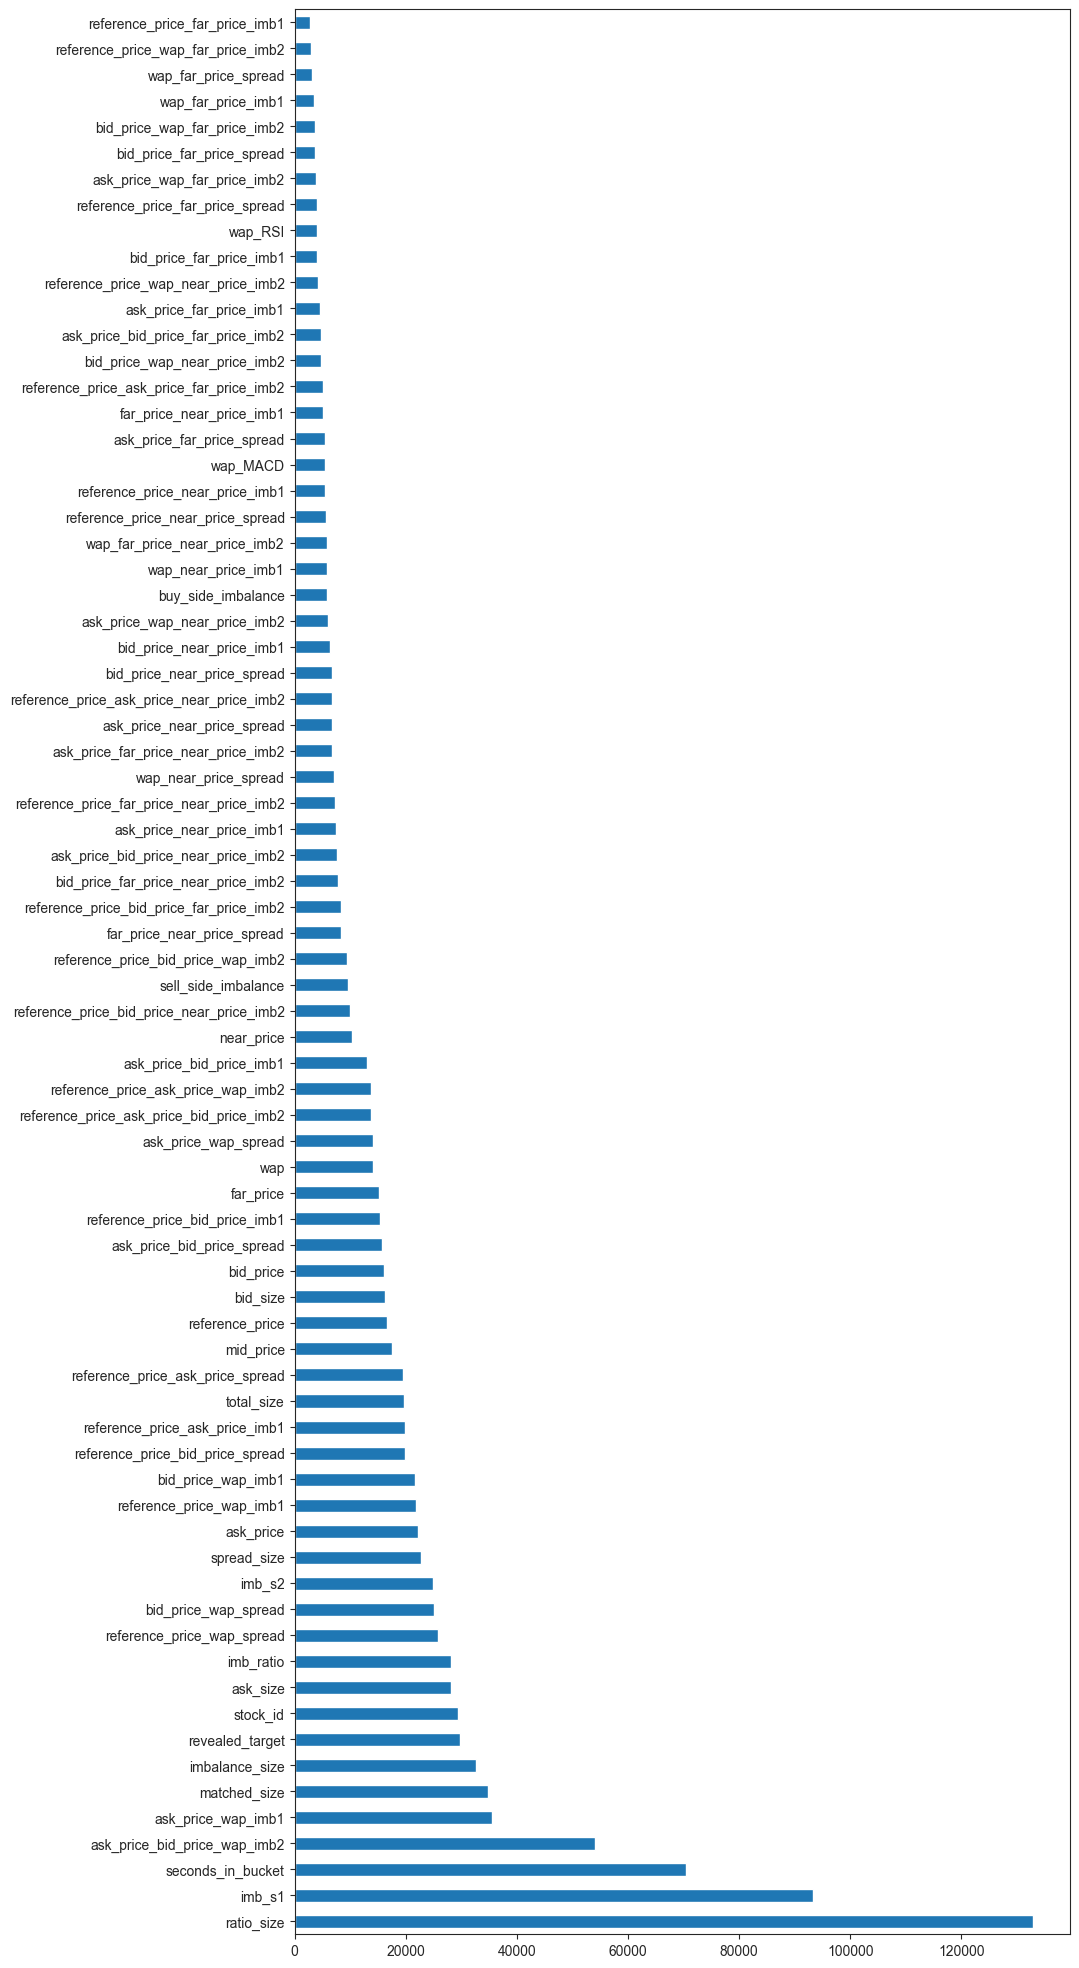

In [17]:
agreggated_feature_importances = (sum([model.booster_.feature_importance(importance_type="gain") \
                                       for model in trained_models])/len(trained_models)).astype(np.int32)

agreggated_feature_importances = pd.Series(agreggated_feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 25))
agreggated_feature_importances.plot(kind='barh')

In [18]:
from utils.files import dump_json

CFG.FEAT_COUNT = -1
if CFG.FEAT_COUNT > 0:
    selected_features = list(agreggated_feature_importances.index[:CFG.FEAT_COUNT]) # Select the desired results
else:
    selected_features = list(df.columns) # Select all

# Add essential features if not in the selected features
selected_features.extend(["stock_id", "seconds_in_bucket"])
selected_features = list(dict.fromkeys(selected_features))

logger.info("Selected features are: ")
pprint(selected_features)

selected_features_dict = {"selected_features": selected_features,
                          "stock_weights": WEIGHTS}
dump_json(CFG.JOB_PATH.joinpath(CFG.SELECTED_FEATURES), selected_features_dict, indent=4)

2023-10-29 21:57:56.766 | INFO     | __main__:<module>:13 - Selected features are: 


['stock_id',
 'seconds_in_bucket',
 'imbalance_size',
 'reference_price',
 'matched_size',
 'far_price',
 'near_price',
 'bid_price',
 'bid_size',
 'ask_price',
 'ask_size',
 'wap',
 'target',
 'total_size',
 'spread_size',
 'ratio_size',
 'imb_ratio',
 'imb_s1',
 'imb_s2',
 'sell_side_imbalance',
 'buy_side_imbalance',
 'mid_price',
 'reference_price_ask_price_spread',
 'reference_price_ask_price_imb1',
 'reference_price_bid_price_spread',
 'reference_price_bid_price_imb1',
 'reference_price_wap_spread',
 'reference_price_wap_imb1',
 'reference_price_far_price_spread',
 'reference_price_far_price_imb1',
 'reference_price_near_price_spread',
 'reference_price_near_price_imb1',
 'ask_price_bid_price_spread',
 'ask_price_bid_price_imb1',
 'ask_price_wap_spread',
 'ask_price_wap_imb1',
 'ask_price_far_price_spread',
 'ask_price_far_price_imb1',
 'ask_price_near_price_spread',
 'ask_price_near_price_imb1',
 'bid_price_wap_spread',
 'bid_price_wap_imb1',
 'bid_price_far_price_spread',
 'bid